## Use Google Cloud ML Engine

I used Google Cloud ML Engine to train uplift model for the entire dataset

### Overview of Data

In [48]:
import datetime
import os
import subprocess
import sys
import json
import xgboost
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from IPython.display import clear_output
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# Fill in your Cloud Storage bucket name
BUCKET_NAME = 'capstone-project-229521'

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading data from Bucket directly is actually much faster than loading from Bigquery.

In [18]:
uplift_data_filename = 'criteo-uplift.csv'
data_dir = 'gs://capstone-project-229521/'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', '-o', 'GSUtil:parallel_composite_upload_threshold=150M', 'cp', os.path.join(data_dir, uplift_data_filename), uplift_data_filename])

0

In [19]:
# Load data into pandas
uplift = pd.read_csv(uplift_data_filename)

uplift = uplift.drop(['visit', 'exposure'], axis=1)

In [20]:
# normalize
df=(uplift-uplift.min())/(uplift.max()-uplift.min())
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
0,1.0,0.0,0.909820,1.0,0.0,0.0,1.0,1.0,0.951115,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.941173,1.0,0.0,0.0,1.0,1.0,0.951115,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.895906,1.0,0.0,0.0,1.0,1.0,0.951115,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.941306,1.0,0.0,0.0,1.0,1.0,0.951115,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.995832,1.0,0.0,0.0,1.0,1.0,0.951115,0.0,1.0,0.0,0.0,0.0


In [ ]:
len(df)

### Format data for prediction
Create an input.json file with each input instance on a separate line. 

In [21]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[['treatment','conversion']], test_size=0.1, random_state=35)

In [104]:
with open('input.json', 'w') as outfile:
  json.dump(X_test.to_json(orient='values'), outfile)

### Write the cells out to Python files

- We need to write python files for our model, and then submit it to the ML engine.
- I used two-model approach since transformed outcome approach didn't show significant better performance.

* Random Forest

First algorithm I tried is Random Forest

In [153]:
%writefile trainer/uplift_randomforest.py
import datetime
import os
import subprocess
import sys
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Fill in your Cloud Storage bucket name
BUCKET_NAME = 'capstone-project-229521'

uplift_data_filename = 'criteo-uplift.csv'
data_dir = 'gs://capstone-project-229521/'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', '-o', 'GSUtil:parallel_composite_upload_threshold=150M', 'cp', os.path.join(data_dir, uplift_data_filename), uplift_data_filename])

# Load data into pandas, then use `.values` to get NumPy arrays
uplift = pd.read_csv(uplift_data_filename)
uplift = uplift.drop(['visit', 'exposure'], axis=1)

# normalize
df=(uplift-uplift.min())/(uplift.max()-uplift.min())

# split the data
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[['treatment','conversion']], stratify= df['conversion'], test_size=0.1, random_state=35)

# Train the model
clf = RandomForestClassifier(n_estimators=50, max_depth=69, min_samples_split=139)

# treatment
# fits on treatment group and predicts probability PT (Y = 1|X ) 
fit_t = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 1], y_train['conversion'][y_train.treatment == 1])
pt_pred = fit_t.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yt_pred = fit_t.predict(X_test[X_train.columns[:-1]])

# control
# fits on control group and predicts PC (Y = 1|X )
fit_c = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 0], y_train['conversion'][y_train.treatment == 0])
pc_pred = fit_c.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yc_pred = fit_c.predict(X_test[X_train.columns[:-1]])

# [START train-and-save-model]
u = pt_pred - pc_pred
test_df = y_test
test_df['pt'] = pt_pred
test_df['pc'] = pc_pred
test_df['rf'] = u
test_df['yt'] = yt_pred
test_df['yc'] = yc_pred
test_df['yt'] = test_df['yt'].astype(np.int64)
test_df['yc'] = test_df['yc'].astype(np.int64)
test_df['treatment'] = test_df['treatment'].astype(np.int64)
test_df['conversion'] = test_df['conversion'].astype(np.int64)

# Export the test  to a file
model_filename = 'randomforest_test.joblib'
joblib.dump(test_df, model_filename)
# [END train-and-save-model]

# [START upload-model]
# Upload the saved model file to Cloud Storage
gcs_model_path = os.path.join('gs://', BUCKET_NAME, model_filename)
subprocess.check_call(['gsutil', 'cp', model_filename, gcs_model_path])
# [END upload-model]

Overwriting trainer/uplift_randomforest.py


In [111]:
%writefile trainer/uplift_xgboost.py
import datetime
import os
import subprocess
import sys
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import xgboost
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Fill in your Cloud Storage bucket name
BUCKET_NAME = 'capstone-project-229521'

uplift_data_filename = 'criteo-uplift.csv'
data_dir = 'gs://capstone-project-229521/'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', '-o', 'GSUtil:parallel_composite_upload_threshold=150M', 'cp', os.path.join(data_dir, uplift_data_filename), uplift_data_filename])

# Load data into pandas, then use `.values` to get NumPy arrays
uplift = pd.read_csv(uplift_data_filename)
uplift = uplift.drop(['visit', 'exposure'], axis=1)

# normalize
df=(uplift-uplift.min())/(uplift.max()-uplift.min())

# split the data
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[['treatment','conversion']], stratify= df['conversion'], test_size=0.1, random_state=35)


spw_t = (y_train[y_train.treatment == 1]['conversion'].shape[0] - y_train[y_train.treatment == 1]['conversion'].sum()) / y_train[y_train.treatment == 1]['conversion'].sum()
spw_c = (y_train[y_train.treatment == 0]['conversion'].shape[0] - y_train[y_train.treatment == 0]['conversion'].sum()) / y_train[y_train.treatment == 0]['conversion'].sum()

# train model with balanced dataset 
clf_t= xgboost.XGBClassifier(scale_pos_weight=spw_t)
clf_c= xgboost.XGBClassifier(scale_pos_weight=spw_c)

# treatment
# fits on treatment group and predicts probability PT (Y = 1|X ) 
fit_t = clf_t.fit(X_train[X_train.columns[:-1]][X_train.treatment == 1], y_train['conversion'][y_train.treatment == 1])
pt_pred = fit_t.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yt_pred = fit_t.predict(X_test[X_train.columns[:-1]])

# control
# fits on control group and predicts PC (Y = 1|X )
fit_c = clf_c.fit(X_train[X_train.columns[:-1]][X_train.treatment == 0], y_train['conversion'][y_train.treatment == 0])
pc_pred = fit_c.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yc_pred = fit_c.predict(X_test[X_train.columns[:-1]])

# [START train-and-save-model]
u = pt_pred - pc_pred
test_df = y_test
test_df['pt'] = pt_pred
test_df['pc'] = pc_pred
test_df['xgb'] = u
test_df['yt'] = yt_pred
test_df['yc'] = yc_pred
test_df['yt'] = test_df['yt'].astype(np.int64)
test_df['yc'] = test_df['yc'].astype(np.int64)
test_df['treatment'] = test_df['treatment'].astype(np.int64)
test_df['conversion'] = test_df['conversion'].astype(np.int64)

# Export the test  to a file
model_filename = 'xgboost_test.joblib'
joblib.dump(test_df, model_filename)
# [END train-and-save-model]

# [START upload-model]
# Upload the saved model file to Cloud Storage
gcs_model_path = os.path.join('gs://', BUCKET_NAME, model_filename)
subprocess.check_call(['gsutil', 'cp', model_filename, gcs_model_path])
# [END upload-model]

Overwriting trainer/uplift_xgboost.py


In [107]:
%writefile trainer/uplift_svm.py
import datetime
import os
import subprocess
import sys
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Fill in your Cloud Storage bucket name
BUCKET_NAME = 'capstone-project-229521'

uplift_data_filename = 'criteo-uplift.csv'
data_dir = 'gs://capstone-project-229521/'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', '-o', 'GSUtil:parallel_composite_upload_threshold=150M', 'cp', os.path.join(data_dir, uplift_data_filename), uplift_data_filename])

# Load data into pandas, then use `.values` to get NumPy arrays
uplift = pd.read_csv(uplift_data_filename)
uplift = uplift.drop(['visit', 'exposure'], axis=1)

# normalize
df=(uplift-uplift.min())/(uplift.max()-uplift.min())

# split the data
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[['treatment','conversion']], stratify= df['conversion'], test_size=0.1, random_state=35)

# Train the model
svm = LinearSVC(random_state = 0, class_weight = 'balanced', dual=False, max_iter=10000)
clf= CalibratedClassifierCV(svm)

# treatment
# fits on treatment group and predicts probability PT (Y = 1|X ) 
fit_t = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 1], y_train['conversion'][y_train.treatment == 1])
pt_pred = fit_t.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yt_pred = fit_t.predict(X_test[X_train.columns[:-1]])

# control
# fits on control group and predicts PC (Y = 1|X )
fit_c = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 0], y_train['conversion'][y_train.treatment == 0])
pc_pred = fit_c.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yc_pred = fit_c.predict(X_test[X_train.columns[:-1]])

# [START train-and-save-model]
u = pt_pred - pc_pred
test_df = y_test
test_df['pt'] = pt_pred
test_df['pc'] = pc_pred
test_df['svm'] = u
test_df['yt'] = yt_pred
test_df['yc'] = yc_pred
test_df['yt'] = test_df['yt'].astype(np.int64)
test_df['yc'] = test_df['yc'].astype(np.int64)
test_df['treatment'] = test_df['treatment'].astype(np.int64)
test_df['conversion'] = test_df['conversion'].astype(np.int64)

# Export the test  to a file
model_filename = 'svm_test.joblib'
joblib.dump(test_df, model_filename)
# [END train-and-save-model]

# [START upload-model]
# Upload the saved model file to Cloud Storage
gcs_model_path = os.path.join('gs://', BUCKET_NAME, model_filename)
subprocess.check_call(['gsutil', 'cp', model_filename, gcs_model_path])
# [END upload-model]

Overwriting trainer/uplift_svm.py


* Logistic Regression

In [12]:
%writefile trainer/uplift_logistic.py
import datetime
import os
import subprocess
import sys
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Fill in your Cloud Storage bucket name
BUCKET_NAME = 'capstone-project-229521'

uplift_data_filename = 'criteo-uplift.csv'
data_dir = 'gs://capstone-project-229521/'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', '-o', 'GSUtil:parallel_composite_upload_threshold=150M', 'cp', os.path.join(data_dir, uplift_data_filename), uplift_data_filename])

# Load data into pandas, then use `.values` to get NumPy arrays
uplift = pd.read_csv(uplift_data_filename)

uplift = uplift.drop(['visit', 'exposure'], axis=1)

# normalize
df=(uplift-uplift.min())/(uplift.max()-uplift.min())

# split the data
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[['treatment','conversion']], stratify= df['conversion'], test_size=0.1, random_state=35)

# Train the model
clf = LogisticRegression()

# treatment
# fits on treatment group and predicts probability PT (Y = 1|X ) 
fit_t = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 1], y_train['conversion'][y_train.treatment == 1])
pt_pred = fit_t.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yt_pred = fit_t.predict(X_test[X_train.columns[:-1]])

# control
# fits on control group and predicts PC (Y = 1|X )
fit_c = clf.fit(X_train[X_train.columns[:-1]][X_train.treatment == 0], y_train['conversion'][y_train.treatment == 0])
pc_pred = fit_c.predict_proba(X_test[X_train.columns[:-1]])[:,1]
yc_pred = fit_c.predict(X_test[X_train.columns[:-1]])

# [START train-and-save-model]
u = pt_pred - pc_pred
test_df = y_test
test_df['pt'] = pt_pred
test_df['pc'] = pc_pred
test_df['lg'] = u
test_df['yt'] = yt_pred
test_df['yc'] = yc_pred
test_df['yt'] = test_df['yt'].astype(np.int64)
test_df['yc'] = test_df['yc'].astype(np.int64)
test_df['treatment'] = test_df['treatment'].astype(np.int64)
test_df['conversion'] = test_df['conversion'].astype(np.int64)

# Export the test  to a file
model_filename = 'logistic_test.joblib'
joblib.dump(test_df, model_filename)
# [END train-and-save-model]

# [START upload-model]
# Upload the saved model file to Cloud Storage
gcs_model_path = os.path.join('gs://', BUCKET_NAME, model_filename)
subprocess.check_call(['gsutil', 'cp', model_filename, gcs_model_path])
# [END upload-model]

Overwriting trainer/uplift_logistic.py


- This step is to configure our trainning model due to the large input size.

In [35]:
%writefile config.yaml
trainingInput:
  scaleTier: CUSTOM
  masterType: complex_model_l

Overwriting config.yaml


In [134]:
%writefile config2.yaml
trainingInput:
  scaleTier: CUSTOM
  masterType: complex_model_l
  workerType: complex_model_l
  parameterServerType: large_model
  workerCount: 9
  parameterServerCount: 3

Writing config2.yaml


- Now we can sumbit the Google Cloud ML Engine jobs

In [81]:
%bash

JOB_NAME="uplift_random_forest_$(date +"%Y%m%d_%H%M%S")"
JOB_DIR=gs://capstone-project-229521/random_forest_job_dir
TRAINING_PACKAGE_PATH="./trainer/"
MAIN_TRAINER_MODULE="trainer.uplift_randomforest"
REGION=us-central1
RUNTIME_VERSION=1.12
PYTHON_VERSION=2.7
SCALE_TIER=BASIC

gcloud ml-engine jobs submit training $JOB_NAME \
  --job-dir $JOB_DIR \
  --package-path $TRAINING_PACKAGE_PATH \
  --module-name $MAIN_TRAINER_MODULE \
  --region $REGION \
  --runtime-version=$RUNTIME_VERSION \
  --python-version=$PYTHON_VERSION \
  --config config.yaml \
  -- \
  --user_first_arg=first_arg_value \
  --user_second_arg=second_arg_value

jobId: uplift_random_forest_20190222_180755
state: QUEUED


Job [uplift_random_forest_20190222_180755] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe uplift_random_forest_20190222_180755

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs uplift_random_forest_20190222_180755


In [93]:
%bash

JOB_NAME="uplift_logistic_$(date +"%Y%m%d_%H%M%S")"
JOB_DIR=gs://capstone-project-229521/random_forest_job_dir
TRAINING_PACKAGE_PATH="./trainer/"
MAIN_TRAINER_MODULE="trainer.uplift_rf_clf"
REGION=us-central1
RUNTIME_VERSION=1.12
PYTHON_VERSION=2.7

gcloud ml-engine jobs submit training $JOB_NAME \
  --job-dir $JOB_DIR \
  --package-path $TRAINING_PACKAGE_PATH \
  --module-name $MAIN_TRAINER_MODULE \
  --region $REGION \
  --runtime-version=$RUNTIME_VERSION \
  --python-version=$PYTHON_VERSION \
  --config config.yaml \
  -- \
  --user_first_arg=first_arg_value \
  --user_second_arg=second_arg_value

jobId: uplift_logistic_20190222_194732
state: QUEUED


Job [uplift_logistic_20190222_194732] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe uplift_logistic_20190222_194732

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs uplift_logistic_20190222_194732


In [133]:
%bash

JOB_NAME="uplift_logistic_$(date +"%Y%m%d_%H%M%S")"
JOB_DIR=gs://capstone-project-229521/random_forest_job_dir
TRAINING_PACKAGE_PATH="./trainer/"
MAIN_TRAINER_MODULE="trainer.uplift_logistic"
REGION=us-central1
RUNTIME_VERSION=1.12
PYTHON_VERSION=2.7

gcloud ml-engine jobs submit training $JOB_NAME \
  --job-dir $JOB_DIR \
  --package-path $TRAINING_PACKAGE_PATH \
  --module-name $MAIN_TRAINER_MODULE \
  --region $REGION \
  --runtime-version=$RUNTIME_VERSION \
  --python-version=$PYTHON_VERSION \
  --config config.yaml \
  -- \
  --user_first_arg=first_arg_value \
  --user_second_arg=second_arg_value

jobId: uplift_logistic_20190222_204352
state: QUEUED


Job [uplift_logistic_20190222_204352] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe uplift_logistic_20190222_204352

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs uplift_logistic_20190222_204352


In [19]:
%bash

JOB_NAME="uplift_xgboost_worker2"
JOB_DIR=gs://capstone-project-229521/random_forest_job_dir
TRAINING_PACKAGE_PATH="./trainer/"
MAIN_TRAINER_MODULE="trainer.uplift_xgboost"
REGION=us-central1
RUNTIME_VERSION=1.12
PYTHON_VERSION=2.7

gcloud ml-engine jobs submit training $JOB_NAME \
  --job-dir $JOB_DIR \
  --package-path $TRAINING_PACKAGE_PATH \
  --module-name $MAIN_TRAINER_MODULE \
  --region $REGION \
  --runtime-version=$RUNTIME_VERSION \
  --python-version=$PYTHON_VERSION \
  --config config2.yaml \
  -- \
  --user_first_arg=first_arg_value \
  --user_second_arg=second_arg_value

jobId: uplift_xgboost_worker2
state: QUEUED


Job [uplift_xgboost_worker2] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe uplift_xgboost_worker2

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs uplift_xgboost_worker2


In [154]:
%bash

JOB_NAME="uplift_randomforest_worker4"
JOB_DIR=gs://capstone-project-229521/random_forest_job_dir
TRAINING_PACKAGE_PATH="./trainer/"
MAIN_TRAINER_MODULE="trainer.uplift_randomforest"
REGION=us-central1
RUNTIME_VERSION=1.12
PYTHON_VERSION=2.7

gcloud ml-engine jobs submit training $JOB_NAME \
  --job-dir $JOB_DIR \
  --package-path $TRAINING_PACKAGE_PATH \
  --module-name $MAIN_TRAINER_MODULE \
  --region $REGION \
  --runtime-version=$RUNTIME_VERSION \
  --python-version=$PYTHON_VERSION \
  --config config2.yaml \
  -- \
  --user_first_arg=first_arg_value \
  --user_second_arg=second_arg_value

jobId: uplift_randomforest_worker4
state: QUEUED


Job [uplift_randomforest_worker4] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe uplift_randomforest_worker4

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs uplift_randomforest_worker4


## Prediction

Actually, we do not need to use gcloud ml-engine predict for the project.

In [ ]:
gcloud ml-engine models create "[YOUR-MODEL-NAME]"

MODEL_DIR="gs://your_bucket_name/"
VERSION_NAME="[YOUR-VERSION-NAME]"
MODEL_NAME="[YOUR-MODEL-NAME]"
FRAMEWORK="SCIKIT_LEARN"

gcloud ml-engine versions create $VERSION_NAME \
    --model $MODEL_NAME --origin $MODEL_DIR \
    --runtime-version=1.12 --framework $FRAMEWORK \
    --python-version=3.5

gcloud ml-engine versions describe $VERSION_NAME \
    --model $MODEL_NAME

MODEL_NAME="[YOUR-MODEL-NAME]"
VERSION_NAME="[YOUR-VERSION-NAME]"
INPUT_FILE="input.json"

gcloud ml-engine predict --model $MODEL_NAME --version \
  $VERSION_NAME --json-instances $INPUT_FILE

## Results

As long as we obtained the resulting files from gcloud ml-engine, we can draw the uplift curve and evaluate the qini measures.

### Combine the Results

- I used stratified random train/test splits.
- Maybe we can do 30 stratified random splits, and obtain the average.

In [53]:
# Load in rogistic regression results
BUCKET_NAME = 'capstone-project-229521'

test_model = 'logistic_test.joblib'
data_dir = 'gs://capstone-project-229521/'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', 'cp', os.path.join(data_dir, test_model), test_model])

0

In [54]:
lg_df = joblib.load(test_model)
lg_df.head()

,treatment,conversion,pt,pc,lg,yt,yc
10413941,0,0,0.001044,0.001231,-0.000187,0,0
16893334,1,0,0.000273,0.000172,0.000101,0,0
9072123,1,0,0.000796,0.000522,0.000274,0,0
9143938,1,0,0.000630,0.000573,0.000057,0,0
4462152,1,0,0.001044,0.001231,-0.000187,0,0


In [55]:
# Load in random forest results
test_model = 'randomforest_test.joblib'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', 'cp', os.path.join(data_dir, test_model), test_model])

0

In [56]:
rf_df = joblib.load(test_model)
rf_df.head()

,treatment,conversion,pt,pc,rf,yt,yc
10413941,0,0,0.001342,0.001786,-0.000444,0,0
16893334,1,0,0.000000,0.000114,-0.000114,0,0
9072123,1,0,0.000932,0.002119,-0.001187,0,0
9143938,1,0,0.000000,0.000000,0.000000,0,0
4462152,1,0,0.001342,0.001786,-0.000444,0,0


In [57]:
test_df = pd.merge(lg_df, rf_df, left_index=True, right_index=True, suffixes=('_lg', '_rf'))
test_df.head()

,treatment_lg,conversion_lg,pt_lg,pc_lg,lg,yt_lg,yc_lg,treatment_rf,conversion_rf,pt_rf,pc_rf,rf,yt_rf,yc_rf
10413941,0,0,0.001044,0.001231,-0.000187,0,0,0,0,0.001342,0.001786,-0.000444,0,0
16893334,1,0,0.000273,0.000172,0.000101,0,0,1,0,0.000000,0.000114,-0.000114,0,0
9072123,1,0,0.000796,0.000522,0.000274,0,0,1,0,0.000932,0.002119,-0.001187,0,0
9143938,1,0,0.000630,0.000573,0.000057,0,0,1,0,0.000000,0.000000,0.000000,0,0
4462152,1,0,0.001044,0.001231,-0.000187,0,0,1,0,0.001342,0.001786,-0.000444,0,0


In [58]:
# Load in xgboost results
test_model = 'xgboost_test.joblib'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', 'cp', os.path.join(data_dir, test_model), test_model])

0

In [59]:
xgb_df = joblib.load(test_model)
xgb_df.head()

,treatment,conversion,pt,pc,xgb,yt,yc
10413941,0,0,0.353179,0.494245,-0.141066,0,0
16893334,1,0,0.101431,0.036390,0.065041,0,0
9072123,1,0,0.456996,0.472226,-0.015230,0,0
9143938,1,0,0.103905,0.127644,-0.023739,0,0
4462152,1,0,0.353179,0.494245,-0.141066,0,0


In [60]:
# Load in svm results
test_model = 'svm_test.joblib'

# gsutil outputs everything to stderr so we need to divert it to stdout.
subprocess.check_call(['gsutil', 'cp', os.path.join(data_dir, test_model), test_model])

0

In [61]:
svm_df = joblib.load(test_model)
svm_df.head()

,treatment,conversion,pt,pc,svm,yt,yc
10413941,0,0,0.000986,0.001252,-0.000266,0,0
16893334,1,0,0.000250,0.000124,0.000126,0,0
9072123,1,0,0.000705,0.000418,0.000287,0,0
9143938,1,0,0.000757,0.000724,0.000033,0,0
4462152,1,0,0.000986,0.001252,-0.000266,0,0


In [62]:
test_df2 = pd.merge(xgb_df, svm_df, left_index=True, right_index=True, suffixes=('_xgb', '_svm'))
test_df2.head()

,treatment_xgb,conversion_xgb,pt_xgb,pc_xgb,xgb,yt_xgb,yc_xgb,treatment_svm,conversion_svm,pt_svm,pc_svm,svm,yt_svm,yc_svm
10413941,0,0,0.353179,0.494245,-0.141066,0,0,0,0,0.000986,0.001252,-0.000266,0,0
16893334,1,0,0.101431,0.036390,0.065041,0,0,1,0,0.000250,0.000124,0.000126,0,0
9072123,1,0,0.456996,0.472226,-0.015230,0,0,1,0,0.000705,0.000418,0.000287,0,0
9143938,1,0,0.103905,0.127644,-0.023739,0,0,1,0,0.000757,0.000724,0.000033,0,0
4462152,1,0,0.353179,0.494245,-0.141066,0,0,1,0,0.000986,0.001252,-0.000266,0,0


In [63]:
test_df = pd.merge(test_df, test_df2, left_index=True, right_index=True)
test_df.head()

,treatment_lg,conversion_lg,pt_lg,pc_lg,lg,yt_lg,yc_lg,treatment_rf,conversion_rf,pt_rf,...,xgb,yt_xgb,yc_xgb,treatment_svm,conversion_svm,pt_svm,pc_svm,svm,yt_svm,yc_svm
10413941,0,0,0.001044,0.001231,-0.000187,0,0,0,0,0.001342,...,-0.141066,0,0,0,0,0.000986,0.001252,-0.000266,0,0
16893334,1,0,0.000273,0.000172,0.000101,0,0,1,0,0.000000,...,0.065041,0,0,1,0,0.000250,0.000124,0.000126,0,0
9072123,1,0,0.000796,0.000522,0.000274,0,0,1,0,0.000932,...,-0.015230,0,0,1,0,0.000705,0.000418,0.000287,0,0
9143938,1,0,0.000630,0.000573,0.000057,0,0,1,0,0.000000,...,-0.023739,0,0,1,0,0.000757,0.000724,0.000033,0,0
4462152,1,0,0.001044,0.001231,-0.000187,0,0,1,0,0.001342,...,-0.141066,0,0,1,0,0.000986,0.001252,-0.000266,0,0


In [64]:
test_df['treatment'] = test_df.treatment_lg
test_df['conversion'] = test_df.conversion_lg

### Treatment Accuracies

We can see the **accuracy** for the treatment model to predict the treatments is **99.76%**.

In [14]:
accuracy_lg = accuracy_score(test_df[test_df.treatment==1]['conversion'], test_df[test_df.treatment==1]['yt_lg'])
accuracy_rf = accuracy_score(test_df[test_df.treatment==1]['conversion'], test_df[test_df.treatment==1]['yt_rf'])
accuracy_xgb = accuracy_score(test_df[test_df.treatment==1]['conversion'], test_df[test_df.treatment==1]['yt_xgb'])
accuracy_svm = accuracy_score(test_df[test_df.treatment==1]['conversion'], test_df[test_df.treatment==1]['yt_svm'])

print("Logistic Regression Accuracy: %.2f%%" % (accuracy_lg * 100.0))
print("Random Forest Accuracy: %.2f%%" % (accuracy_rf * 100.0))
print("XGBoost Accuracy: %.2f%%" % (accuracy_xgb * 100.0))
print("SVM Accuracy: %.2f%%" % (accuracy_svm * 100.0))

Logistic Regression Accuracy: 99.76%
Random Forest Accuracy: 99.76%
XGBoost Accuracy: 91.07%
SVM Accuracy: 99.76%


### Gain Curve

Before we explore Uplift specific evaluation metrics, it is useful to create a gains chart and Gini coefficient, as traditional metrics used in Uplift modeling can be thought of as a generalization of the Gini coefficient. 
    
To create a gains chart we follow a few simple steps:

1. Sort by probability of conversion (descending). 
2. Create array for cumulative sum of conversions.
3. Create array for number of users targeted. 
4. Plot targeted users on the Y axis and conversions on the X axis. 

In [15]:
# add random targeting
np.random.seed(35)

test_df['random_prob'] = [np.random.random() for k in test_df.index]
test_df = test_df.sort_values(by=['random_prob'], ascending=False)
# for treatment results
rand_number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
rand_number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()

# add optimal targeting  
test_df = test_df.sort_values(by=['conversion'], ascending=False)
optimum_number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
optimum_number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()

# add logistic regression  
test_df = test_df.sort_values(by=['lg'], ascending=False)
lg_number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
lg_number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()

# add random forest 
test_df = test_df.sort_values(by=['rf'], ascending=False)
rf_number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
rf_number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()

# add xgboost 
test_df = test_df.sort_values(by=['xgb'], ascending=False)
xgb_number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
xgb_number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()

# add svm 
test_df = test_df.sort_values(by=['svm'], ascending=False)
svm_number_purchases = test_df[test_df.treatment == 1]['conversion'].cumsum()
svm_number_targeted  = test_df[test_df.treatment == 1]['treatment'].cumsum()

Text(0.5,1,u'Gains Chart')

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


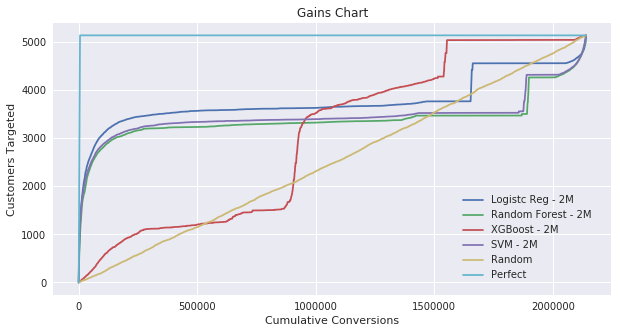

In [16]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(lg_number_targeted, lg_number_purchases, label='Logistc Reg - 2M')
plt.plot(rf_number_targeted, rf_number_purchases, label='Random Forest - 2M')
plt.plot(xgb_number_targeted, xgb_number_purchases, label='XGBoost - 2M')
plt.plot(svm_number_targeted, svm_number_purchases, label='SVM - 2M')
plt.plot(rand_number_targeted, rand_number_purchases, label='Random')
plt.plot(optimum_number_targeted, optimum_number_purchases, label='Perfect')
plt.xlabel("Cumulative Conversions")
plt.ylabel("Customers Targeted")
plt.legend(loc='upper center', bbox_to_anchor=(0.85, 0.4), fancybox=True, shadow=True)
plt.title("Gains Chart")

In [17]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

gini_predictions_lg = gini(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt_lg'])
gini_max = gini(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['conversion'])
ngini_lg = gini_normalized(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt_lg'])

gini_predictions_rf = gini(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt_rf'])
ngini_rf = gini_normalized(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt_rf'])

gini_predictions_xgb = gini(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt_xgb'])
ngini_xgb = gini_normalized(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt_xgb'])

gini_predictions_svm = gini(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt_svm'])
ngini_svm = gini_normalized(test_df[test_df.treatment == 1]['conversion'], test_df[test_df.treatment == 1]['yt_svm'])

print('For Logistic Regression: Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_predictions_lg, gini_max, ngini_lg))
print('For Random Forest: Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_predictions_rf, gini_max, ngini_rf))
print('For XGBoost: Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_predictions_xgb, gini_max, ngini_xgb))
print('For SVM: Gini: %.3f, Max. Gini: %.3f, Normalized Gini: %.3f' % (gini_predictions_svm, gini_max, ngini_svm))

For Logistic Regression: Gini: 0.175, Max. Gini: 0.499, Normalized Gini: 0.351
For Random Forest: Gini: 0.174, Max. Gini: 0.499, Normalized Gini: 0.350
For XGBoost: Gini: 0.300, Max. Gini: 0.499, Normalized Gini: 0.602
For SVM: Gini: 0.175, Max. Gini: 0.499, Normalized Gini: 0.351


### Uplift Curve

In [18]:
control_total   = test_df[test_df.treatment == 0].shape[0]
treatment_total = test_df[test_df.treatment == 1].shape[0]
N = len(test_df)

uplift = pd.DataFrame({'segment': np.arange(0, 1.05, .05), 'control_pop': np.arange(0, 1.05, .05) * control_total,
                       'treatment_pop': np.arange(0, 1.05, .05) * treatment_total})

# format the counts to inte
uplift['treatment_pop'] = uplift['treatment_pop'].astype(int)
uplift['control_pop'] = uplift['control_pop'].astype(int)

# uplift curve for logistic regression using two-model approach
uplift['lg_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['lg'], ascending=False)['conversion'][:x].sum())
uplift['lg_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['lg'] , ascending=False)['conversion'][:x].sum())

# uplift curve for random forest using two-model approach
uplift['rf_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['rf'], ascending=False)['conversion'][:x].sum())
uplift['rf_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['rf'] , ascending=False)['conversion'][:x].sum())

# uplift curve for xgboost using two-model approach
uplift['xgb_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['xgb'], ascending=False)['conversion'][:x].sum())
uplift['xgb_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['xgb'] , ascending=False)['conversion'][:x].sum())

# uplift curve for xgboost using two-model approach
uplift['svm_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['svm'], ascending=False)['conversion'][:x].sum())
uplift['svm_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['svm'] , ascending=False)['conversion'][:x].sum())


# randome curve is the baseline
uplift['rand_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['random_prob'], ascending=False)['conversion'][:x].sum())
uplift['rand_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['random_prob'], ascending=False)['conversion'][:x].sum())

# for perfect we need to sort by incremental 
uplift['perfect_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['conversion'], ascending=False)['conversion'][:x].sum())
uplift['perfect_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['conversion'] )['conversion'][:x].sum())

# sleeping dogs
uplift['pract_tk'] = uplift['treatment_pop'].apply(lambda x: test_df[test_df.treatment == 1].sort_values(by=['conversion'], ascending=False)['conversion'][:x].sum())
uplift['pract_ck'] = uplift['control_pop'].apply(lambda x: test_df[test_df.treatment == 0].sort_values(by=['conversion'], ascending=False )['conversion'][:x].sum())

# calculate uplift 
uplift['uplift_lg'] = uplift['lg_tk'] - uplift['lg_ck']
uplift['uplift_rf'] = uplift['rf_tk'] - uplift['rf_ck']
uplift['uplift_xgb'] = uplift['xgb_tk'] - uplift['xgb_ck']
uplift['uplift_svm'] = uplift['svm_tk'] - uplift['svm_ck']
uplift['rand'] = uplift['rand_tk'] - uplift['rand_ck']
uplift['perfect'] = uplift['perfect_tk'] - uplift['perfect_ck']
uplift['pract'] = uplift['pract_tk'] - uplift['pract_ck']

uplift['uplift_ratio_lg'] = uplift['uplift_lg'] / N
uplift['uplift_ratio_rf'] = uplift['uplift_rf'] / N
uplift['uplift_ratio_xgb'] = uplift['uplift_xgb'] / N
uplift['uplift_ratio_svm'] = uplift['uplift_svm'] / N
uplift['rand_ratio'] = uplift['rand'] / N
uplift['perfect_ratio'] = uplift['perfect'] / N
uplift['pract_ratio'] = uplift['pract'] / N

uplift = uplift.fillna(0)

/usr/local/envs/py2env/lib/python2.7/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


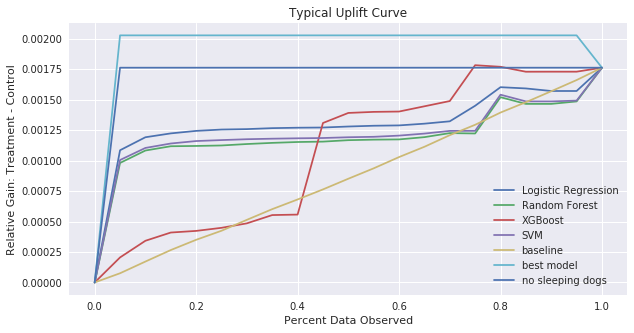

In [19]:
uplift.plot(kind='line',x='segment',y=['uplift_ratio_lg', 'uplift_ratio_rf', 'uplift_ratio_xgb', 'uplift_ratio_svm', 'rand_ratio', 'perfect_ratio', 'pract_ratio'])
plt.legend(['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'baseline', 'best model', 'no sleeping dogs'])
plt.ylabel('Relative Gain: Treatment - Control')  
plt.xlabel('Percent Data Observed')
plt.title('Typical Uplift Curve')
plt.show()

### Area Under Uplift Curve (AUUC) 

Area Under Uplift Curve (AUUC) is based on lift curves which represent the proportion of positive outcomes (the sensitivity) as a function of the percentage of the individuals selected. Lift curve has the same ordinate as the ROC, but a different abscissa. Uplift curve is defined as the difference in lift produced by a classifier between treatment and control groups, at a particular threshold percentage k/n of all examples. 

In [21]:
AUUC_lg = (uplift.uplift_ratio_lg.sum() - uplift.rand_ratio.sum())*.05
AUUC_rf = (uplift.uplift_ratio_rf.sum() - uplift.rand_ratio.sum())*.05
AUUC_xgb = (uplift.uplift_ratio_xgb.sum() - uplift.rand_ratio.sum())*.05
AUUC_svm = (uplift.uplift_ratio_svm.sum() - uplift.rand_ratio.sum())*.05

print('Logistic Regression AUUC: %f' % AUUC_lg)
print('Random Forest AUUC: %f' % AUUC_rf)
print('XGBoost AUUC: %f' % AUUC_xgb)
print('SVM AUUC: %f' % AUUC_svm)

Logistic Regression AUUC: 0.000448
Random Forest AUUC: 0.000336
XGBoost AUUC: 0.000211
SVM AUUC: 0.000361


### From Gini to Qini 

Now, using the Gini metric/curve for evaluating an Uplift Modeling doesn't make as much sense as we don't know the true counterfactual outcome. That is, we want to see how well our Uplift model is at predicting uplift, but since we don't know the outcome of the counterfactual (i.e. what somebody would have done given other action), we can't plot this at an individual level. 

However, we can compare segments of the population. For example, we can sort the dataframe by uplift score (descending). Then for each decile in test and control we calculate the number of positive outcomes. We then subtract the number of positive outcomes in treatment minus the number in control. This give us incremental sales or uplift per decile. 

Now let's step back, for a second, and think about why this makes sense. If we sort by uplift and segment test and control populations by decile, the first decile in the test group should have a large number of converters. These are people how we predicted would convert when shown an ad, and since they are in the treatment group they were shown and ad. Furthermore, we would expect the control to have a low number of conversions. We also predicted they'd convert if shown and ad, however they were not shown and ad, so their likelihood of converting is, most likely, very small. Ideally we will see the highest uplift in the first decile, then it should decrease and level off until the last deciles where we could/should see negative uplift. If we see negative uplift (downlift) in segments we are observing what is known as sleeping dogs (customers who will buy without seeing and ad, but will not buy if they do see an ad). 

Below, we will build a model for the control group. We will then subtract the output probabilities of the test model and control model to come up with predicted uplift (two-model approach), after which we will build an Uplift plot. 


/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encounter

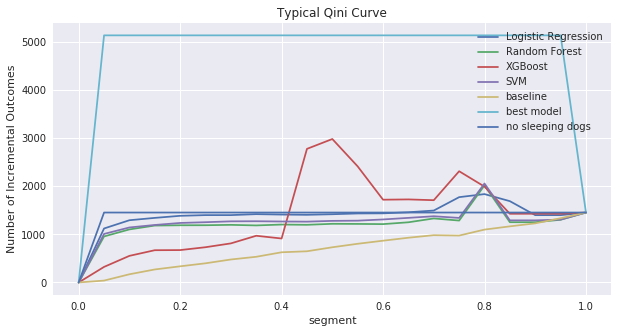

In [22]:
# calculate qini 
uplift['uplift_qini_lg'] = uplift.apply(lambda x: x['lg_tk'] - x['lg_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['uplift_qini_rf'] = uplift.apply(lambda x: x['rf_tk'] - x['rf_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['uplift_qini_xgb'] = uplift.apply(lambda x: x['xgb_tk'] - x['xgb_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['uplift_qini_svm'] = uplift.apply(lambda x: x['svm_tk'] - x['svm_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['rand_qini'] = uplift.apply(lambda x: x['rand_tk'] - x['rand_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['perfect_qini'] = uplift.apply(lambda x: x['perfect_tk'] - x['perfect_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)
uplift['pract_qini'] = uplift.apply(lambda x: x['pract_tk'] - x['pract_ck'] * x['treatment_pop'] / x['control_pop'], axis=1)

uplift['k'] = uplift['treatment_pop'] + uplift['control_pop']

uplift = uplift.fillna(0)

# Draw typical Qini curve
uplift.plot(kind='line',x='segment',y=['uplift_qini_lg', 'uplift_qini_rf', 'uplift_qini_xgb', 'uplift_qini_svm', 'rand_qini', 'perfect_qini', 'pract_qini'])
plt.legend(['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'baseline', 'best model', 'no sleeping dogs'])
plt.ylabel('Number of Incremental Outcomes')  
#plt.xlabel('Number Targeted')
plt.title('Typical Qini Curve')
plt.show()

In [25]:
qini_lg = (uplift.uplift_qini_lg.sum() - uplift.rand_qini.sum())/(uplift.perfect_qini.sum() - uplift.rand_qini.sum())
qini_rf = (uplift.uplift_qini_rf.sum() - uplift.rand_qini.sum())/(uplift.perfect_qini.sum() - uplift.rand_qini.sum())
qini_xgb = (uplift.uplift_qini_xgb.sum() - uplift.rand_qini.sum())/(uplift.perfect_qini.sum() - uplift.rand_qini.sum())
qini_svm = (uplift.uplift_qini_svm.sum() - uplift.rand_qini.sum())/(uplift.perfect_qini.sum() - uplift.rand_qini.sum())

print('Logistic Regression Qini coefficient Q: %.4f' % qini_lg)
print('Random Forest Qini coefficient Q: %.4f' % qini_rf)
print('XGBoost Qini coefficient Q: %.4f' % qini_xgb)
print('SVM Qini coefficient Q: %.4f' % qini_svm)

Logistic Regression Qini coefficient Q: 0.1656
Random Forest Qini coefficient Q: 0.1206
XGBoost Qini coefficient Q: 0.1661
SVM Qini coefficient Q: 0.1330


### Use Pylift for Evaluation

Evaluate all four models over the entire dataset using Pylift package.

In [44]:
%bash
git clone https://github.com/wayfair/pylift
cd pylift
pip install .

Processing /content/uplift/eda_notebooks/pylift
  Running setup.py bdist_wheel for pylift: started
  Running setup.py bdist_wheel for pylift: finished with status 'done'
  Stored in directory: /tmp/pip-ephem-wheel-cache-vbk7mwkj/wheels/7f/68/0b/d0dae567cafe08db4a8aba89e2bf214bc1e2c8f02835cd6951
Successfully built pylift
  Found existing installation: pylift 0.0.1
    Uninstalling pylift-0.0.1:
      Successfully uninstalled pylift-0.0.1


Cloning into 'pylift'...


In [18]:
#To update
#%bash
#git pull origin master
#pip install --upgrade --no-cache-dir 

Merge made by the 'recursive' strategy.
 MM.ipynb                                           | 1351 +++++++
 NN.ipynb                                           | 3003 ++++++++++++++++
 model_eval/readme.md                               |    1 +
 two_model_approach/Model Evaluation Test.ipynb     | 3698 ++++++++++++++++++++
 .../Two-Model Approach_Mingyuan.ipynb              |  883 +++++
 5 files changed, 8936 insertions(+)
 create mode 100644 MM.ipynb
 create mode 100644 NN.ipynb
 create mode 100644 model_eval/readme.md
 create mode 100644 two_model_approach/Model Evaluation Test.ipynb
 create mode 100644 two_model_approach/Two-Model Approach_Mingyuan.ipynb


From https://github.com/cloud36/uplift_modeling_criteo
 * branch            master     -> FETCH_HEAD
   d3bbb7b..4e68e51  master     -> origin/master
ERROR: You must give at least one requirement to install (see "pip help install")


In [45]:
cd .

/content/uplift/eda_notebooks


In [49]:
import pylift

In [51]:
from pylift.pylift import TransformedOutcome

In [52]:
from pylift.pylift.eval import UpliftEval

- Logistic Regression

In [65]:
test = test_df
test = test.sort_values(by=['lg'], ascending=False)

In [70]:
upev_lg = UpliftEval(test['treatment'], test['conversion'], test['lg'] , n_bins=10)

In [71]:
upev_lg.q1_qini

0.14479331798704415

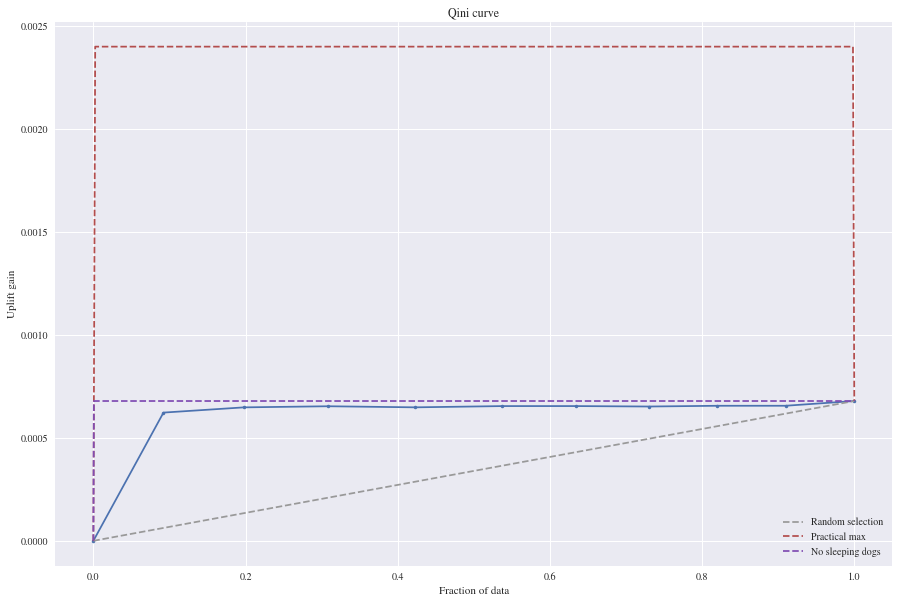

In [72]:
upev_lg.plot(plot_type='qini',show_practical_max=True, show_no_dogs=True)

- Random Forest

In [73]:
test = test.sort_values(by=['rf'], ascending=False)
upev_rf = UpliftEval(test['treatment'], test['conversion'], test['rf'] , n_bins=10)
upev_rf.q1_qini

0.1064234102961073

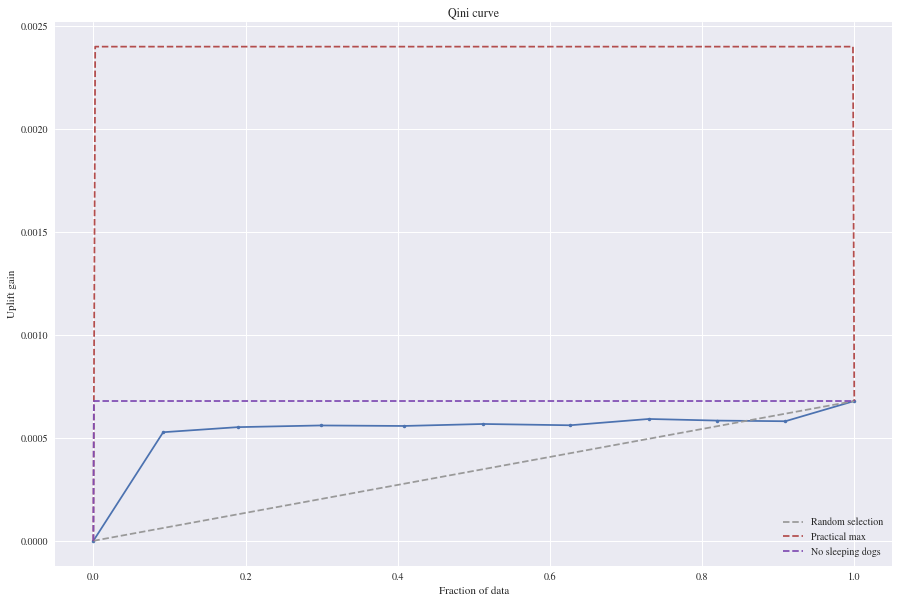

In [74]:
upev_rf.plot(plot_type='qini',show_practical_max=True, show_no_dogs=True)

- XGBoost

In [76]:
test = test.sort_values(by=['xgb'], ascending=False)
upev_xgb = UpliftEval(test['treatment'], test['conversion'], test['xgb'] , n_bins=10)
upev_xgb.q1_qini

0.07670295582788794

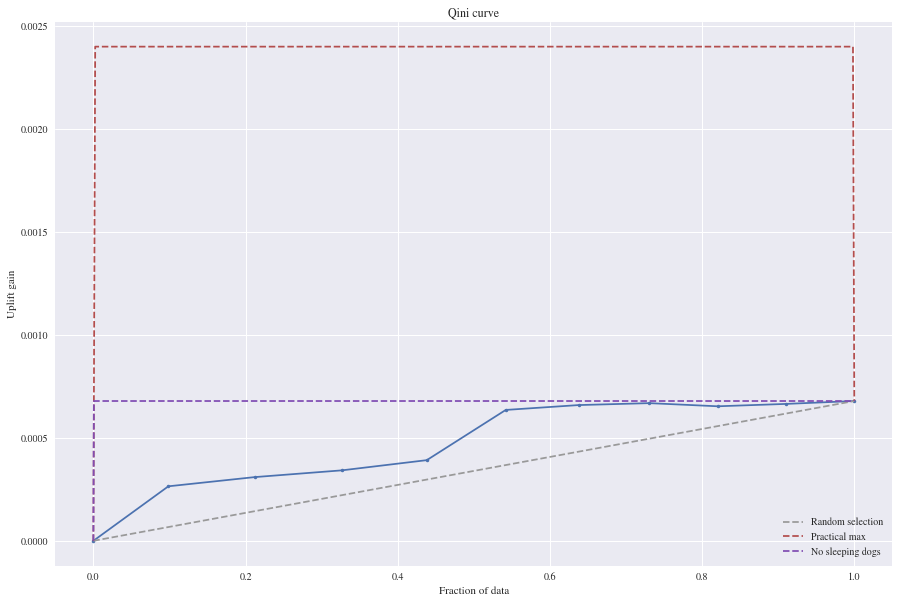

In [77]:
upev_xgb.plot(plot_type='qini',show_practical_max=True, show_no_dogs=True)

- Support Vector Machine

In [78]:
test = test.sort_values(by=['svm'], ascending=False)
upev_svm = UpliftEval(test['treatment'], test['conversion'], test['svm'] , n_bins=10)
upev_svm.q1_qini

0.1169769749660008

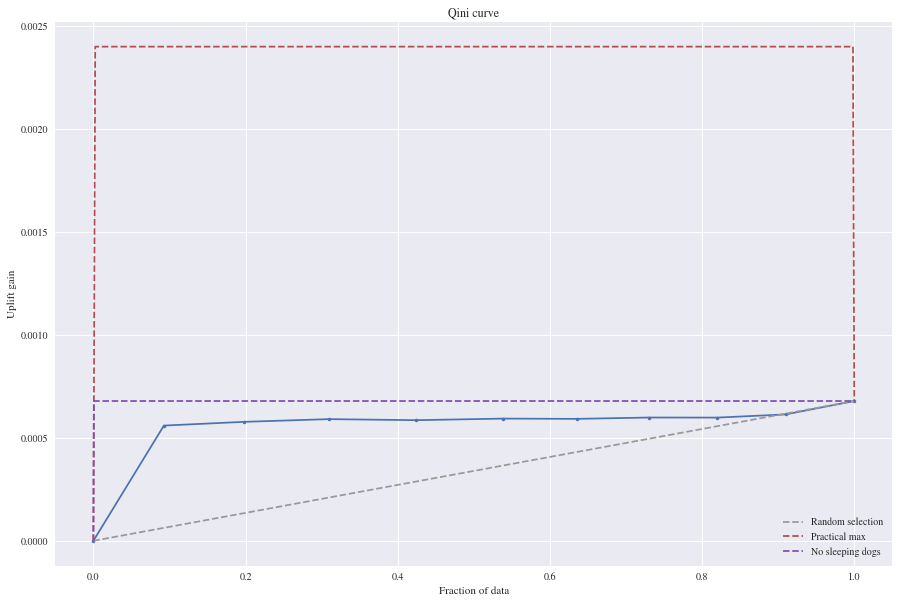

In [79]:
upev_svm.plot(plot_type='qini',show_practical_max=True, show_no_dogs=True)